In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(22*22*64, 64)
        self.fc2 = nn.Linear(64, 10)
      

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
# Some other functions:
def Accuracy(dataloader,model):     
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data in dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total

class CNNModel:
  def __init__(self, batch_size,epochs,lr):
    self.batchSize = batch_size
    self.epochs = epochs
    self.learningRate = lr
    self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    self.trainloader = None
    self.valLoader = None
    self.AccTrain = []
    self.AccVal = []
    self.Epoch = []
    self.Model = None
    self.best = None

  def loadData(self):
    # Data transformations 
    normal_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    flip_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #,transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32)
        ])
    # Data Loading 

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=flip_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batchSize,
                                              shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=normal_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=self.batchSize,
                                            shuffle=False, num_workers=2)
    self.trainloader = trainloader
    self.valLoader = testloader
    print("Data Loaded")

  def train(self):
    bestAcc = 0
    batches = 50000/self.batchSize
    Train_Acc=[]
    Test_Acc=[]
    Epochs=[]
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(self.epochs):  
      running_loss = 0.0
      for i, data in enumerate(self.trainloader, 0):
          inputs, labels = data
          images = inputs.to(device)
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # Forward Pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backpropagation and optimizatuon

          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # if i % 4000 == 3999:    # print every 2000 mini-batches
      print(f' Epoch: {epoch + 1} loss: {running_loss / batches:.3f}')
      val_loss = running_loss / batches
      scheduler.step(val_loss)
      running_loss = 0.0
      with torch.no_grad():
        testAcc = Accuracy(self.valLoader,model)
        trainAcc = Accuracy(self.trainloader, model)
        Train_Acc.append(trainAcc)
        Test_Acc.append(testAcc)
        Epochs.append(epoch+1)
        print(f'Accuracy of the network on the 10000 test images: {testAcc} %')
        print(f'Accuracy of the network on the train images: {trainAcc} %')
        if(testAcc>bestAcc):
          self.best = model
          bestAcc = testAcc
    self.Model = model
    self.AccVal = Test_Acc
    self.AccTrain = Train_Acc
    self.Epoch = Epochs

def drawAcc(TrainAcc,TestAcc,Epoch):
  x = Epoch
  y1= TrainAcc
  y2 = TestAcc

  plt.plot(x,y1,color='blue',label = 'Training Accuracy') # for training data 
  plt.plot(x,y2,color='red',label= 'Validation Accuracy') # for test data 
  plt.legend()
  plt.show()


In [ ]:

M = CNNModel(10,12,0.001)
M.loadData()
M.train() 
model = M.Model
trainloader = M.trainloader
valLoader = M.valLoader
# print("=====================================")
# print("---------("+"lr = "+str(lr)+" )----------")
drawAcc(M.AccTrain,M.AccVal,M.Epoch)
accT = Accuracy(trainloader,model)
accV = Accuracy(valLoader,model)
# ValAcc.append(accV)
# TrainAcc.append(accT)

100%|██████████| 170498071/170498071 [00:01<00:00, 91960007.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data Loaded
 Epoch: 1 loss: 1.791
Accuracy of the network on the 10000 test images: 42.56 %
Accuracy of the network on the train images: 43.666 %
 Epoch: 2 loss: 1.594
Accuracy of the network on the 10000 test images: 43.61 %
Accuracy of the network on the train images: 47.076 %
 Epoch: 3 loss: 1.488
Accuracy of the network on the 10000 test images: 46.4 %
Accuracy of the network on the train images: 51.142 %
 Epoch: 4 loss: 1.394
Accuracy of the network on the 10000 test images: 46.45 %
Accuracy of the network on the train images: 53.886 %
 Epoch: 5 loss: 1.340
Accuracy of the network on the 10000 test images: 47.38 %
Accuracy of the network on the train images: 58.24 %
 Epoch: 6 loss: 1.270
Accuracy of the network on the 10000 test images: 46.92 %
Accuracy of the network on the train images: 60.376 %
 Epoch: 7 loss: 1.232
Accuracy of the network on the 10000 test images: 47.4 %
Accuracy of the ne

NameError: ignored

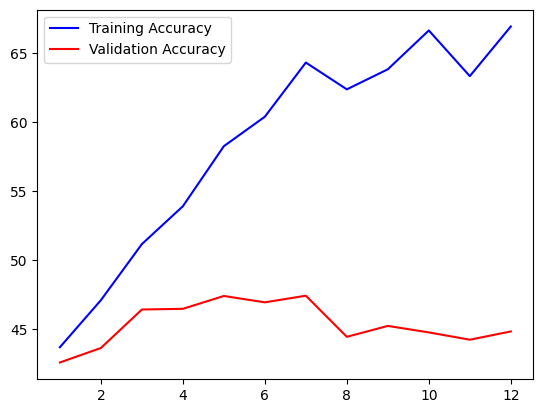

In [ ]:
drawAcc(M.AccTrain,M.AccVal,M.Epoch)

In [ ]:
normal_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

flip_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #,transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32)
    ])
# Data Loading 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=flip_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=normal_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                        shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print("The Best Testing Accuracy:")
# Bestmodel = M.best
print("Accuracy for the best model is 47.38%")


The Best Testing Accuracy:
Accuracy for the best model is 47.38%


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(22*22*64, 64)
        self.fc2 = nn.Linear(64, 10)
      

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
# Some other functions:
def Accuracy(dataloader,model):     
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data in dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total

class CNNModel:
  def __init__(self, batch_size,epochs,lr):
    self.batchSize = batch_size
    self.epochs = epochs
    self.learningRate = lr
    self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    self.trainloader = None
    self.valLoader = None
    self.AccTrain = []
    self.AccVal = []
    self.Epoch = []
    self.Model = None
    self.best = None

  def loadData(self):
    # Data transformations 
    normal_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    flip_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #,transforms.RandomHorizontalFlip(), transforms.RandomCrop(size=32)
        ])
    # Data Loading 

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=flip_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batchSize,
                                              shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=normal_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=self.batchSize,
                                            shuffle=False, num_workers=2)
    self.trainloader = trainloader
    self.valLoader = testloader
    print("Data Loaded")

  def train(self):
    bestAcc = 0
    batches = 50000/self.batchSize
    Train_Acc=[]
    Test_Acc=[]
    Epochs=[]
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(self.epochs):  
      running_loss = 0.0
      for i, data in enumerate(self.trainloader, 0):
          inputs, labels = data
          images = inputs.to(device)
          labels = labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # Forward Pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backpropagation and optimizatuon

          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          # if i % 4000 == 3999:    # print every 2000 mini-batches
      print(f' Epoch: {epoch + 1} loss: {running_loss / batches:.3f}')
      val_loss = running_loss / batches
      scheduler.step(val_loss)
      running_loss = 0.0
      with torch.no_grad():
        testAcc = Accuracy(self.valLoader,model)
        trainAcc = Accuracy(self.trainloader, model)
        Train_Acc.append(trainAcc)
        Test_Acc.append(testAcc)
        Epochs.append(epoch+1)
        print(f'Accuracy of the network on the 10000 test images: {testAcc} %')
        print(f'Accuracy of the network on the train images: {trainAcc} %')
        if(testAcc>bestAcc):
          self.best = model
          bestAcc = testAcc
    self.Model = model
    self.AccVal = Test_Acc
    self.AccTrain = Train_Acc
    self.Epoch = Epochs

def drawAcc(TrainAcc,TestAcc,Epoch):
  x = Epoch
  y1= TrainAcc
  y2 = TestAcc

  plt.plot(x,y1,color='blue',label = 'Training Accuracy') # for training data 
  plt.plot(x,y2,color='red',label= 'Validation Accuracy') # for test data 
  plt.legend()
  plt.show()


In [ ]:
M = CNNModel(10,12,0.001)
M.loadData()
M.train() 
model = M.Model
trainloader = M.trainloader
valLoader = M.valLoader
# print("=====================================")
# print("---------("+"lr = "+str(lr)+" )----------")
drawAcc(M.AccTrain,M.AccVal,M.Epoch)
accT = Accuracy(trainloader,model)
accV = Accuracy(valLoader,model)
# ValAcc.append(accV)
# TrainAcc.append(accT)

In [ ]:
drawAcc(M.AccTrain,M.AccVal,M.Epoch)